In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm.autonotebook import tqdm

/tmp/ipykernel_212510/987820437.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import mctspy as mct

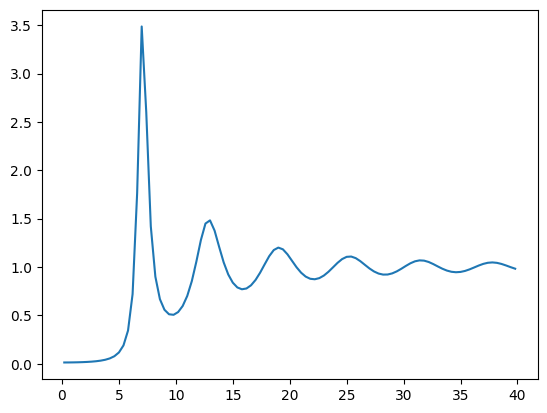

In [4]:
Sq = mct.structurefactors.hssPY(0.51593)
qgrid = np.linspace(0.2,39.8,100)
sq,cq = Sq.Sq(qgrid)
plt.plot(qgrid,sq)
plt.show()

In [5]:
model = mct.simple_liquid_model(Sq,qgrid)

In [6]:
nep = mct.nonergodicity_parameter (model = model, maxiter=1500)
nep.solve()

In [7]:
cs = mct.structurefactors.hssPYtagged(phi=Sq.phi,delta=1)
model_s = mct.tagged_particle_model (model, cs=cs, D0s=1)
nep_s = mct.nonergodicity_parameter (model = model_s, maxiter=1500)
nep_s.solve()

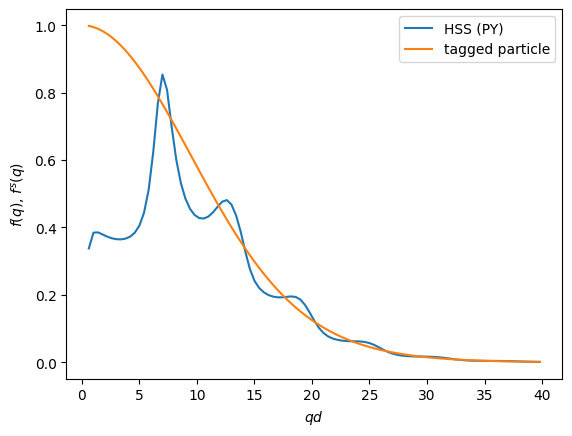

In [8]:
plt.plot(nep.model.q[1:], nep.f[1:], label='HSS (PY)')
plt.plot(nep_s.model.q[1:], nep_s.f[1:], label='tagged particle')
plt.xlabel(r'$qd$')
plt.ylabel(r'$f(q)$, $f^s(q)$')
plt.legend()
plt.show()

In [9]:
def calc_ev(phi):
    Sq = mct.structurefactors.hssPY(phi)
    model = mct.simple_liquid_model (Sq, qgrid)
    nep = mct.nonergodicity_parameter (model = model)
    nep.solve()
    ev = mct.eigenvalue(nep)
    ev.solve()
    return ev
phis, evs = mct.util.evscan(0.51,0.52,calc_ev,eps=1e-8)

In [10]:
# The following should print phi_c = 0.51591214(1), lambda = 0.735, ev = 0.999844
p=np.argmax([ev.eval for ev in evs])
print("phi_c = {:.8f}(1), lambda = {:.3f}, ev = {:.6f}".format(phis[p],evs[p].lam,evs[p].eval))

phi_c = 0.51591214(1), lambda = 0.735, ev = 0.999844


In [11]:
hss_c = evs[p]

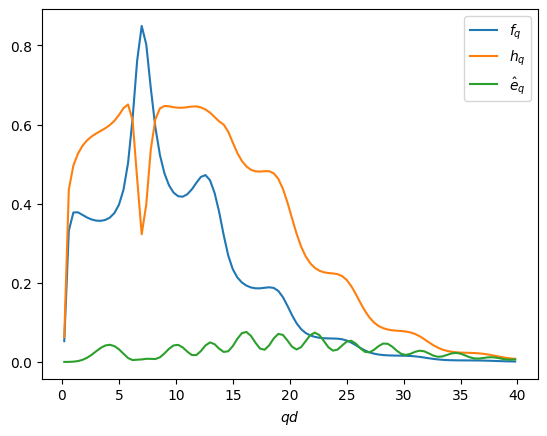

In [12]:
plt.plot(qgrid,hss_c.nep.f,label=r'$f_q$')
plt.plot(qgrid,hss_c.e*(1-hss_c.nep.f)**2,label=r'$h_q$')
plt.plot(qgrid,hss_c.ehat,label=r'$\hat e_q$')
plt.legend()
plt.xlabel(r'$qd$')
plt.show()

In [13]:
Sq = mct.structurefactors.hssPY(0.515)
model = mct.simple_liquid_model(Sq,qgrid)
phi = mct.correlator (model = model, store=True)

In [14]:
pbar = tqdm(total=phi.blocks+1)
phi.solve_all(callback=lambda d,bs2,bs,c: pbar.update(1))
pbar.close()

  0%|          | 0/61 [00:00<?, ?it/s]

In [15]:
qvals = [3.4,7.4,12.2]
qis = np.array([np.nonzero(np.isclose(qgrid,qval)) for qval in qvals],dtype=int).reshape(-1)

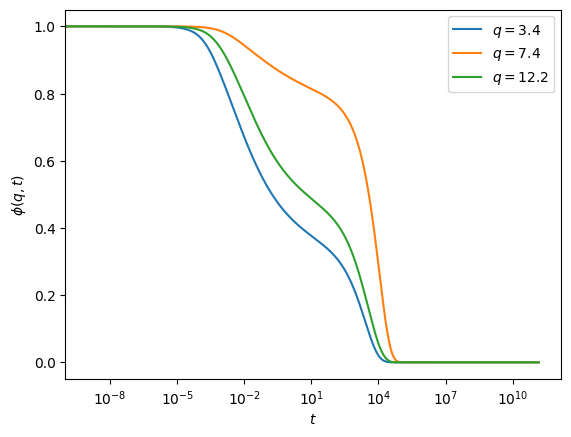

In [16]:
for qi in qis:
    plt.plot(phi.t, phi.phi[:,qi], label=r'$q = {:.1f}$'.format(qgrid[qi]))
plt.xscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$\phi(q,t)$')
plt.legend()
plt.show()

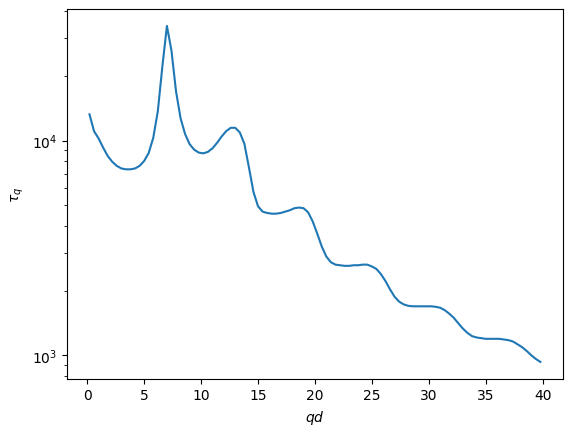

In [17]:
tau_indices = phi.phi.shape[0] - np.sum(phi.phi/nep.f<=0.1,axis=0)
tau_indices[tau_indices>=phi.phi.shape[0]] = -1
tau = phi.t[tau_indices]
plt.plot(model.q,tau)
plt.yscale('log')
plt.xlabel(r'$qd$')
plt.ylabel(r'$\tau_q$')
plt.show()

In [18]:
cs = mct.structurefactors.hssPYtagged(phi=Sq.phi,delta=1)
model_s = mct.tagged_particle_model (model, cs=cs, D0s=1)
phi_s = mct.correlator (model = model_s, base=phi, store = True)
correlators = mct.CorrelatorStack([phi,phi_s])

In [19]:
model_s0 = mct.tagged_particle_q0 (model_s)
msd = mct.mean_squared_displacement (model = model_s0, base=phi_s, store=True)
correlators.append(msd)

In [20]:
model_ngp = mct.tagged_particle_ngp (model_s0)
ngp = mct.non_gaussian_parameter (model = model_ngp, base=msd, store=True)
correlators.append(ngp)

In [21]:
pbar = tqdm(total=phi.blocks+1)
correlators.solve_all(callback=lambda d,bs2,bs,c: pbar.update(1))
pbar.close()

  0%|          | 0/61 [00:00<?, ?it/s]

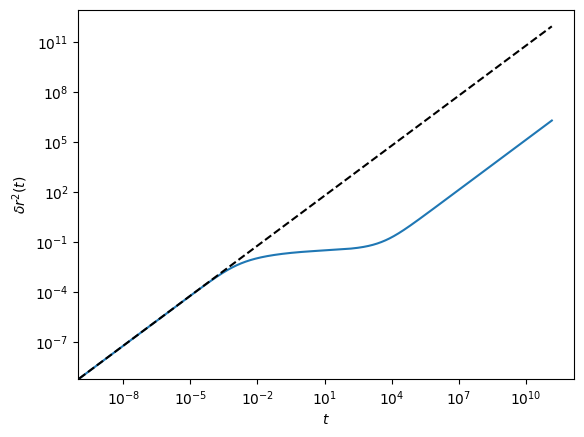

In [22]:
plt.plot(msd.t, msd.phi[:,0])
plt.plot(msd.t, 6*msd.t, color='black', linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$\delta r^2(t)$')
plt.show()

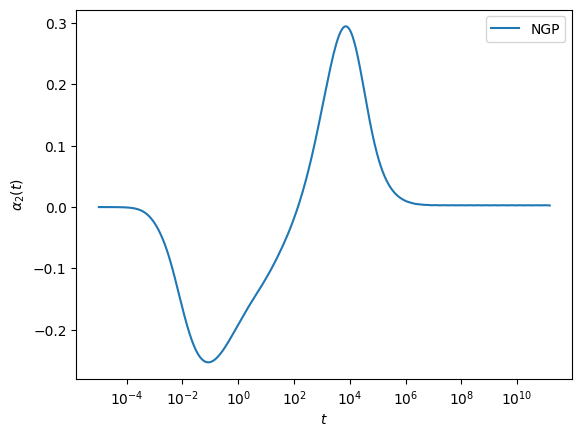

In [23]:
plt.plot(ngp.t[ngp.t>1e-5], (ngp.phi[:,0][ngp.t>1e-5]/ngp.phi[:,1][ngp.t>1e-5]**2 - 1), label='NGP')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$\alpha_2(t)$')
plt.show()

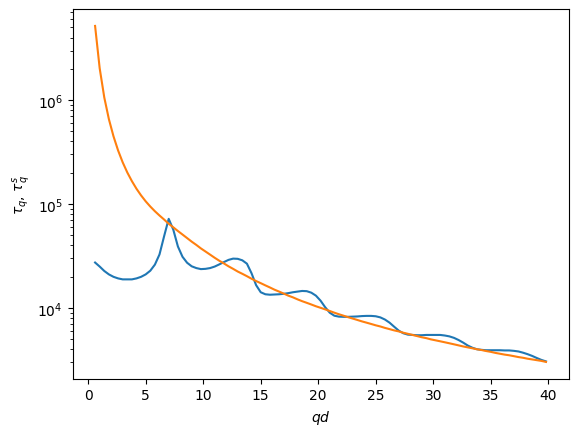

In [24]:
for corr,f in [(phi,nep.f),(phi_s,nep_s.f)]:
    tau_indices = corr.phi.shape[0] - np.sum(corr.phi/f<=0.01,axis=0)
    tau_indices[tau_indices>=corr.phi.shape[0]] = -1
    tau = corr.t[tau_indices]
    plt.plot(model.q[1:],tau[1:])
plt.yscale('log')
plt.xlabel(r'$qd$')
plt.ylabel(r'$\tau_q$, $\tau^s_q$')
plt.show()